

*   Azhar Shaikh: nr: 270184, VUnet id: ash241
*   Don Mani: nr: 269343, VUnet id: dmi670
*   Venkat Mohit Sornapudi: nr: 2721697 VUnet id: vsi410







# Assignment 4 - Graph Convolutional Networks
## Deep Learning Course - Vrije Universiteit Amsterdam, 2021

#### Instructions on how to use this notebook:

This notebook is hosted on Google Colab. To be able to work on it, you have to create your own copy. Go to *File* and select *Save a copy in Drive*.

You can also avoid using Colab entirely, and download the notebook to run it on your own machine. If you choose this, go to *File* and select *Download .ipynb*.

The advantage of using Colab is that you can use a GPU. You can complete this assignment with a CPU, but it will take a bit longer. Furthermore, we encourage you to train using the GPU not only for faster training, but also to get experience with this setting. This includes moving models and tensors to the GPU and back. This experience is vary valuable because for many interesting models and large datasets (like large CNNs for ImageNet, or Transformer models trained on Wikipedia), training on GPU is the only feasible way.

The default Colab runtime does not have a GPU. To change this, go to *Runtime - Change runtime type*, and select *GPU* as the hardware accelerator. The GPU that you get changes according to what resources are available at the time, and its memory can go from a 5GB, to around 18GB if you are lucky. If you are curious, you can run the following in a code cell to check:

```sh
!nvidia-smi
```

Note that despite the name, Google Colab does  not support collaborative work without issues. When two or more people edit the notebook concurrently, only one version will be saved. You can choose to do group programming with one person sharing the screen with the others, or make multiple copies of the notebook to work concurrently.

**Submission:** Upload your notebook in .ipynb format to Canvas. The code and answers to the questions in the notebook are sufficient, no separate report is expected. 

In [ ]:
!nvidia-smi

Sun Dec 19 18:44:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Introduction

Graphs are very useful data structures that allow us to represent sets of entities and the way they are related among each other. In a graph, entities are also known as *nodes*, and any link between entities is also called an *edge*.

Examples of real world objects that can be modeled as graphs are social networks, where entities are people and relations denote friendship; and molecules, where entities are atoms and relations indicate a bond between them.

There has been increased interest in the recent years in the application of deep learning architectures to graph-structured data, for tasks like predicting missing relations between entities, classifying entities, and classifying graphs. This interest has been spurred by the introduction of Graph Convolutional Networks (GCNs).

In this assignment, you will implement and experiment with one of the first versions of the GCN, proposed by Thomas Kipf and Max Welling in their 2017 paper, [Semi-supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907). In particular, the goals of this assignment are to

- Understand how GCNs are formulated
- Implement the GCN using PyTorch
- Train and evaluate a model for semi-supervised node classification in citation networks
- Train and evaluate a model for binary classification of molecules

### Representing graphs

Suppose we have the following graph:

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/01-graph.png" width="200">

This is an undirected graph (since the edges have no specified direction) with 4 nodes. One way to represent the connectivity structure of the graph is by means of the **adjacency matrix**. The $i$-th row of the matrix contains a 1 in the $j$-th column, if nodes $i$ and $j$ are connected. For an undirected graph like the one above, this means that the adjacency matrix

- Is symmetric (e.g. an edge between 0 and 2 is equivalent as an edge between 2 and 0)
- Is square, of size $n\times n$ where $n$ is the number of nodes

The adjacency matrix for the graph above is then the following:

$$
A =
\begin{bmatrix}
0 & 0 & 1 & 0 \\ 
0 & 0 & 1 & 0 \\
1 & 1 & 0 & 1 \\
0 & 0 & 1 & 0
\end{bmatrix}
$$

A second matrix of interest is the **degree matrix**. This is a diagonal matrix where the $i$-th element of the diagonal indicates the number of edges connected to node $i$. Note that these can be obtained from $A$ by summing across the columns, or the rows. For our example, the degree matrix is

$$
D = \begin{bmatrix}
1 & 0 & 0 & 0 \\ 
0 & 1 & 0 & 0 \\
0 & 0 & 3 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

For specific applications, each node in the graph will have an associated vector of features $x\in\mathbb{R}^c$. If our graph is a social network, then the vector of features can contain information like age, location, and musical tastes, in a specific numeric format. In the case of a molecule, the node could represent an atom and have features like the atomic mass, etc. We can lay out the features in a matrix $X\in\mathbb{R}^{n\times c}$, so that the feature vector for node $i$ is in the $i$-th row.

### Loading a citation network

To move to a real world example, we will start with the Cora dataset. This dataset represents a citation network, where nodes are scientific publications, edges denote citations between them, and features are a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) extracted from their contents.

This graph contains labels for nodes, that represent a specific topic. We will use these for a node classification task.

To easily load it, we will use [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/index.html) (PyG), a deep learning library for graph-structured data.

In [ ]:
# Install PyTorch Geometric
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu113.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim 
from scipy.sparse import coo_matrix, diags, eye, identity, block_diag
import matplotlib.pyplot as plt
import torch_scatter

We can now use the library to download and import the dataset. Initializing the `Planetoid` class returns a `Dataset` object that can contain multiple graphs. In this task we will only use the `Cora` dataset (the citation network) and hence, we will select only the first element.

In [ ]:
from torch_geometric.datasets import Planetoid
data = Planetoid(root='data/Planetoid', name='Cora')[0]


#### Question 1 (0.25 pt)

The `data` object is an instance of the `Data` class in PyG. Check the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html) and report the following properties of the graph:

- Number of nodes
- Number of edges 
- The dimension $d$ of the feature vectors $x\in\mathbb{R}^d$
- The number of targets for the classification task

In [ ]:
# nodes
n_nodes = data.num_nodes
print(f'Number of nodes: {n_nodes}')

Number of nodes: 2708


In [ ]:
# edges
n_edges = data.num_edges
print(f'Number of edges: {n_edges}')

Number of edges: 10556


In [ ]:
n_features = data.x.shape[1] # features
print(f'The dimension d of the feature vectors: {n_features}')

The dimension d of the feature vectors: 1433


In [ ]:
n_classes = len(torch.unique(data.y)) #classes
print(f'The number of targets for the classification task: {n_classes}')

The number of targets for the classification task: 7


#### Question 2 (0.25 pt)

In PyG, edges are provided in a tensor of shape (2, number of edges). You can access it via `data.edge_index`. Each column in this tensor contains the IDs for two nodes that are connected in the graph.

We saw that in an undirected graph, an edge between nodes $i$ and $j$ adds a value of 1 to positions $(i, j)$ and $(j, i)$ of the adjacency matrix. Is this also true for the edge index? That is, if there is an edge $(i, j)$ in `data.edge_index`, is there also an edge for $(j, i)$? This is important to know for the next steps of the implementation.

In [ ]:
# Your answer here
edge_indxs = data.edge_index
edge_indxs

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [ ]:
# by assertion by loop
for first_indx in edge_indxs[0,:]:
  indx_comb_list = np.array([edge_indxs[:,indx_comb[1]].numpy() for indx_comb in (edge_indxs == first_indx).nonzero(as_tuple=False)])
  for indx_comb in indx_comb_list:
    assert indx_comb[::-1] in indx_comb_list  # checking whether reversed index combination exists in the edge indices
# So yes, it is true for the edge index that whenever edge (i,j) exist, that (j,i) also exists.

#### Question 3 (0.25 pt)

In graphs, especially large ones, the adjacency matrix is **sparse**: most entries are zero. Sparse matrices allow for efficient storage and computation.

To prepare and pre-process sparse matrices, we will use [`scipy.sparse`](https://docs.scipy.org/doc/scipy/reference/sparse.html). Once the matrices are ready, we will convert them to PyTorch tensors.

We will use the [Sparse COO format](https://en.wikipedia.org/wiki/Sparse_matrix#Coordinate_list_(COO)). We encourage you to first get familiar with how it works after continuing with the assignment.

- Use the [`scipy.sparse.coo_matrix()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html) function to build the adjacency matrix. Think of what arguments are needed, and how you can obtain them from the graph data loaded above.
- Use the `sum()` method of sparse matrices, together with `scipy.sparse.diags()`, to compute the degree matrix using the definition above.

Both resulting matrices must be sparse of type `float32`.

In [ ]:
# Build the adjacency matrix
data_edges = np.ones([n_edges], dtype=np.float32)
i, j = edge_indxs[0,:], edge_indxs[1,:]
shape = (n_nodes, n_nodes)
A = coo_matrix((data_edges, (i,j)), shape)

# Build the degree matrix
# Only sum one row because we shouldn't count connections twice.
summed = A.sum(axis=0, dtype=np.float32)
D = diags(summed, [0,], shape=shape, format="coo")

You might wonder why we suggest to use a scipy sparse matrix, while also PyTorch supports them. The reason is that in the next step, we will be multiplying two sparse matrices, an operation not supported in PyTorch. PyTorch only allows multiplying a sparse matrix with a dense one, something which we will be doing at a later stage.



### The Graph Convolutional Network

The goal of the graph convolution is to take the feature vectors of all nodes $X\in\mathbb{R}^{n\times c}$, and propagate them along the existing edges, to obtain updated representations $Z\in\mathbb{R}^{n\times d}$.


The GCN is initially motivated as performing a convolution, similarly as it is done in CNNs for images, for graph-structured data. In Kipf and Welling (2017), a theoretical derivation leads to the following formula:

$$
Z = \tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}XW
$$

where

- $W\in\mathbb{R}^{c\times d}$ is a matrix of parameters to be learned via gradient descent
- $\tilde{A} = A + I_n$, where $I_n$ is an $n\times n$ identity matrix
- $\tilde{D}$ is the degree matrix computed with $\tilde{A}$ as the adjacency matrix

If we define $\hat{A} = \tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}$, the graph convolution can be written as $Z = \hat{A}XW$.

#### Question 4 (0.25 pt)

Given the formula for the GCN, explain why it operates by propagating feature vectors across the graph. To answer this, it might be useful to recall the definitions of the adjacency and degree matrices, and how they are involved in the formula.

We can think of the multiplication with the adjacency matrix A as a operation that propagates information about neighbours of any given node into a node. Adding a self-loop ($\tilde{A}= A + I$) to the node enables propagation of the node's feature vector to itself. Using WX using a neural network gives us an updated hidden representation which is again propogated using the propogation rule $$
Z = \tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}XW
$$therefore enabling model to learn information about all the nodes in the graph. We normalise the $\tilde{A}$ with $\tilde{D}$ the degree matrix to get the  normalized adjacancy matrix $\hat{A}$ , this normalises the effect of the number of incoming edges for node and helps avoid numerical instabilities
and exploding/vanishing gradients.

#### Question 5 (0.5 pt)

Compute the **normalized adjacency matrix** $\hat{A}$. The result should be a sparse matrix.

In [ ]:
A_tilde = A + eye(m=A.shape[0], format="coo", dtype=np.float32)
D_tilde = D + identity(n=A_tilde.shape[0], dtype=np.float32, format="coo")
A_norm = ((D_tilde.power(-0.5)).dot(A_tilde)).dot((D_tilde.power(-0.5))).tocoo()

#### Question 6 (0.5 pt)

So far we have used scipy to build and compute sparse matrices. Since we want to train a GCN with PyTorch, we need to convert $\hat{A}$ into a sparse PyTorch tensor. You can do this with the [`torch.sparse_coo_tensor()`](https://pytorch.org/docs/stable/generated/torch.sparse_coo_tensor.html) function, making sure to specify `torch.float` as the type.

In [ ]:
values = A_norm.data
indices = np.vstack((A_norm.row, A_norm.col))
A_norm_tor = torch.sparse_coo_tensor(indices, values)

#### Question 7 (0.5 pt)

We now have all the ingredients to build a GCN layer. Implement a class (inheriting from `torch.nn.Module`) with a learnable matrix of weights $W\in\mathbb{R}^{c\times d}$. Make sure to

- Call this class `GCNLayer`
- The `__init__()` constructor should take as argument the number of input and output features.
- Use `torch.nn.init.kaiming_uniform_` to initialize $W$.
- Define the `forward` method, which takes as input $X$ and $\hat{A}$ and returns $Z$. Note that multiplications involving the sparse matrix $\hat{A}$ have to be done with `torch.spmm`. 

Once you have implemented the class, instantiate a layer with the correct number of input features for the Cora dataset, and a number of output features of your choice. Do a forward pass and report the shape of the output tensor.

In [ ]:
# Your answer here
class GCNlayer(nn.Module):
  def __init__(self, inputs, outputs):
    super(GCNlayer, self).__init__()
    self.gcn_weight = nn.Linear(inputs, outputs, bias=False)
    nn.init.kaiming_uniform_(self.gcn_weight.weight)

  def forward(self, X, A_norm):
    result = torch.spmm(A_norm, X)
    return self.gcn_weight(result)

gcn1 = GCNlayer(n_features, outputs=10)
out = gcn1(data.x, A_norm_tor)
print(f'The Shape of the output Tensor is:{out.size()}')

The Shape of the output Tensor is:torch.Size([2708, 10])


#### Question 8 (0.5 pt)

As we have seen so far, the GCN layer implements a special type of linear transformation of the inputs. However, it is often beneficial in deep learning to stack multiple, non-linear transformations of the input features. Implement a second module class for a model with two GCN layers (use the module you implemented in the previous question).

- Call this class `GCN`
- The constructor must now take as input the number of input features, the output dimension of the first layer (this is the hidden layer), and the output dimension of the output layer.
- In the forward pass, add a ReLU activation function after the first layer.

In [ ]:
# Your answer here
class GCN(nn.Module):
  def __init__(self, in_features, hidden_features, out_features):
    super(GCN, self).__init__()
    self.gcn1 = GCNlayer(in_features, hidden_features)
    self.gcn2 = GCNlayer(hidden_features, out_features)
    self.relu = nn.ReLU()
  
  def forward(self, X, A_norm):
    Z = self.gcn1(X, A_norm)
    Z = self.relu(Z)
    Z = self.gcn2(Z, A_norm)
    return Z

### GCNs for semi-supervised node classification

Now that we have a GCN with two layers, we can test its performance in a node classification task. We will pass the input node features $X$ through the GCN layers, and the output will be of size $n\times k$ where $k$ is the number of classes (which you found in question 1). The label denotes the topic an article in the citation network belongs to (e.g. physics, computer science, etc.).

#### Question 9 (1.5 pt)

Note that the `data` object contains all labels (for all splits) in `data.y`, and binary masks for the train, validation, and test splits in `data.train_mask`, `data.valid_mask`, and `data.test_mask`, respectively. These masks are the same size as `data.y`, and indicate which labels belong to which split.

- Create a GCN with two layers (using the class from the previous question), with 32 as the hidden dimension, and the number of output features equal to the number of classes in the Cora dataset.

- Use the Adam optimizer with a learning rate of 0.01.

- Implement a training loop for the GCN. At each step, pass $X$ and $\hat{A}$ to the GCN to obtain the logits. Compute the mean cross-entropy loss **only for the training instances**, using the binary masks.

- After each training step, evaluate the accuracy for the validation instances.

- Train for 100 epochs. Once training is finished, plot the training loss and validation accuracy (in a graph in function of the epoch number), and report the accuracy in the test set.

You should obtain an accuracy over 75% on both the validation and test sets. You can also compare your results with the original paper, which also contains results for the Cora dataset. Give a brief discussion on the results of your experiments.

Note that in contrast with other tasks, like image classification on some datasets, we don't use mini-batches here. The whole matrix of features and the adjacency is passed to the GCN in one step.

In [ ]:
def train_step(model, X, A_norm_tor, Y, criterion, optimizer, data_indxs):
  out = model(X, A_norm_tor)
  out = out[data_indxs]
  Y = Y[data_indxs]
  loss = criterion(out, Y)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss.item()

def validate(model, X, A_norm_tor, Y, criterion, data_indxs):
  with torch.no_grad():
    out = model(X, A_norm_tor)
    loss = criterion(out[data_indxs], Y[data_indxs])
    preds = out[data_indxs].argmax(dim=1)
    acc = 1.0*(preds==Y[data_indxs])
    acc = acc.mean()
    return acc.item()

def train(model, X, A_norm_tor, Y, masks, criterion, optimizer, epochs):

  train_accs = []
  val_accs = []
  epoch_loss = []

  for epoch in range(1, epochs+1):
    
    loss = train_step(model, X, A_norm_tor, Y, criterion, optimizer, masks['train'])
    train_acc = validate(model, X, A_norm_tor, Y, criterion, masks['train'])
    val_acc = validate(model, X, A_norm_tor, Y, criterion, masks['val'])
    if epoch % 10 == 0 or epoch == 1:
      print(f'Epoch:{epoch}, Loss:{loss}, val acc:{val_acc}, train acc:{train_acc}')
    epoch_loss.append(loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

  return model, train_accs, val_accs, epoch_loss

In [ ]:
masks = {'train':data.train_mask, 'val':data.val_mask, 'test':data.test_mask}
#Hyper - parameters
EPOCHS = 100
LR = 0.01

model = GCN(n_features, 32, n_classes)
optimizer = optim.Adam(model.parameters(), LR)
criterion = nn.CrossEntropyLoss()
model, train_accs, val_accs, epoch_loss = train(model, nn.functional.normalize(data.x, dim=1), A_norm_tor, data.y, masks, criterion, optimizer, epochs=EPOCHS)
print("Test accuracy: ", validate(model, data.x, A_norm_tor, data.y,criterion, masks['test']))

Epoch:1, Loss:1.9474132061004639, val acc:0.49799999594688416, train acc:0.8714285492897034
Epoch:10, Loss:1.3187204599380493, val acc:0.7239999771118164, train acc:0.9785714149475098
Epoch:20, Loss:0.5071156024932861, val acc:0.7739999890327454, train acc:0.9785714149475098
Epoch:30, Loss:0.1432478278875351, val acc:0.7680000066757202, train acc:1.0
Epoch:40, Loss:0.04675739258527756, val acc:0.7699999809265137, train acc:1.0
Epoch:50, Loss:0.021075967699289322, val acc:0.7639999985694885, train acc:1.0
Epoch:60, Loss:0.012429174967110157, val acc:0.7620000243186951, train acc:1.0
Epoch:70, Loss:0.008686828427016735, val acc:0.7639999985694885, train acc:1.0
Epoch:80, Loss:0.0067292130552232265, val acc:0.7680000066757202, train acc:1.0
Epoch:90, Loss:0.0055205500684678555, val acc:0.7639999985694885, train acc:1.0
Epoch:100, Loss:0.00468063959851861, val acc:0.765999972820282, train acc:1.0
Test accuracy:  0.7839999794960022


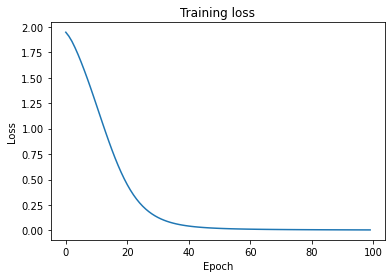

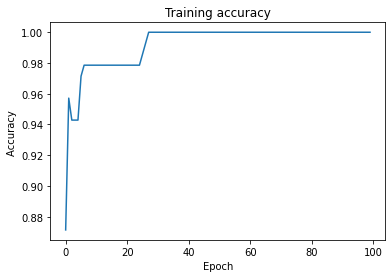

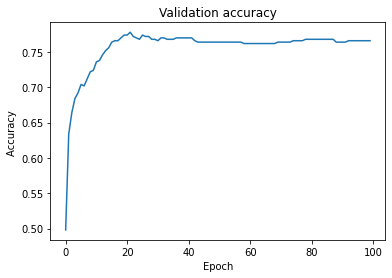

In [ ]:
def show_epoch_plot(y, title, label):
    plt.plot(range(len(y)), y)
    plt.xlabel("Epoch")
    plt.ylabel(label)
    plt.title(title)
    plt.show()

show_epoch_plot(epoch_loss, "Training loss", "Loss")
print("")
show_epoch_plot(train_accs, "Training accuracy", "Accuracy ")
print("")
show_epoch_plot(val_accs, "Validation accuracy", "Accuracy ")

The above experimented resulted in an accuracy of 78.1% on the testset. we observe a final validation accuracy of around 77% from the plots. It is also intresting to observe that the model has completely learned the train dataset as the train loss becomes zero and the train accuracy becomes 100% which usually means the model has overfit but we still get a high validation accuracy and test accuracy implying that the model has generalised well.

The original paper by Thomas Kipf and Max Welling report a accuracy of 81.5% on the testset. The high test accuracy of the original paper can be attributed to hyper parameter tuning and other techniques like dropout and L2 regularisation and early stopping.

#### Question 10 (0.25 pt)

The paper introduces GCNs as a way to solve a *semi-supervised* classification problem.

- What makes this problem semi-supervised?
- What is the proportion of labeled data used for training with respect to labeled data in the validation and test sets? What is difference in this context with other benchmark tasks in machine learning, like image classification with MNIST?
- Why do you think the GCN performs well in this semi-supervised scenario?

- Semi-Supervised learning is a paradigm of machine learning where the model learns from both labelled and unlabeled data. In the case of GCN we get valuable information from the unlabeled data through the graph structure which is encoded as an adjacency matrix.
- We have only 140 nodes labeled for training out of a total of 2708, The ratio of train/val/test splits is 0.09/0.30/0.61. The bench mark tasks like imagenet or MNIST image classification have large train splits compared to the semi-supervised case usually 80% of the data is used for training while the rest is used for validation and testing as the learning can only happen from the labeled data.
- The GCN performs well in the semi-supervised case because it has information about the nodes, edges from the adjacency matrix, this information helps the GCN learn relationships between different nodes
that can help in solving the node classification task.

### Loading a dataset of proteins

In the previous sections you learned how to pass the adjacency matrix of a graph with a couple of thousand of nodes, to classify each node with a particular label. A different and useful application of GCNs is graph classification.

In contrast with the previous part, where there was a single, big graph, in graph classification we have multiple graphs, and each graph can be assigned a label. In this part of the assignment you will implement a classifier for proteins.

[Proteins](https://en.wikipedia.org/wiki/Protein_(nutrient)) are parts of the buildings block of life. They consist of chains of amino acids, and can take many shapes. In the PROTEINS dataset, proteins are represented as graphs, where the nodes are amino acids, and an edge between them indicates that they are 6 [Angstroms](https://en.wikipedia.org/wiki/Angstrom) apart. All graphs have a binary label, where 1 means that the protein is not an enzyme.

We will start by loading and examining this dataset.

In [ ]:
from torch_geometric.datasets import TUDataset
dataset = TUDataset(root='data/TU', name='PROTEINS', use_node_attr=True)

#### Question 11 (0.25 pt)

Unlike in the previous part, where we selected the first element returned by the loading function, note that here we get all the elements returned by `TUDataset()`. `dataset` is an interable object, that has some similar behaviors as a Python list: you can call `len()` on it, and you can takes slices from it.

Each element in `dataset` is a `Data` object containing a graph that represents a protein. This is the same type of object that we used in the previous part to store the Cora citation network.

Knowing this, answer the following:

- How many proteins (graphs) are there in `dataset`?
- Take any protein from `dataset`. How many nodes and edges does it contain? What is its label? How many features does each node have?

In [ ]:
#How many proteins (graphs) are there in dataset?
print(f'Number of graphs in dataset: {len(dataset)}')

Number of graphs in dataset: 1113


In [ ]:
#Take any protein from dataset
dataset[0]

Data(edge_index=[2, 162], x=[42, 4], y=[1])

In [ ]:
#How many nodes 
print(f'Number of nodes in the first graph: {dataset[0].x.shape[0]}')

Number of nodes in the first graph: 42


In [ ]:
#How many edges
print(f'Number of edges in the first graph: {dataset[0].edge_index.shape[1]}')

Number of edges in the first graph: 162


In [ ]:
#What is its label

print(f'Label of the first graph: {dataset[0].y.item()}')
# Since the label is 0, the protein is an enzyme

Label of the first graph: 0


In [ ]:
#How many features 
print(f'The number of features that each node has: {dataset[0].x.shape[1]}')

The number of features that each node has: 4


#### Question 12 (0.5 pt)

To properly train and evaluate our model, we need training, validation, and test splits.

For reproducibility purposes, we generate a random tensor of indices for you. Use it to extract the three splits from `dataset`.

For training, take 80% of the indices (starting from the first element in `indices`), then the following 10% for validation, and the remaining 10% for testing. You can use the indices to index `dataset`.

Call the resulting splits `train_dataset`, `valid_dataset`, and `test_dataset`.

In [ ]:
# Don't erase the following three lines
import torch
torch.random.manual_seed(0)
indices = torch.randperm(len(dataset))

# Your answer here
splits = (int(len(dataset) * 0.8), int( len(dataset) * 0.9))

train_dataset = dataset[indices[:splits[0]]]
valid_dataset = dataset[indices[splits[0]:splits[1]]]
test_dataset = dataset[indices[splits[1]:]]

### Working with a batch of graphs

When working with the Cora dataset, you used the information in `data.edge_index` to build the sparse normalized adjacency matrix $\hat{A}$ that is required by the GCN. We could do something similar here: for each graph, we build $\hat{A}$, and pass it to the GCN. However, if the number of graphs is big, this can really slow down training.

To avoid this, we will resort to a very useful trick that also allows us to reuse the same GCN you implemented previously. The trick makes it possible to do a forward pass through the GCN for multiple, disconnected graphs at the same time (instead of only one), much like when you train with mini-batches for other kinds of data.

Let's first revisit the propagation rule of the GCN, $Z = \hat{A}XW$, with an illustration (we have omitted the cells of $X$ and $W$ for clarity):

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/02-gcn-forward.png">

If we have multiple graphs, we can still use the same propagation rule, if we

- Set $\hat{A}$ to be a block diagonal matrix, where the blocks are the different adjacency matrices of the graphs
- Concatenate the feature matrices along the first dimension

This is illustrated in the following figure, for a batch of 3 graphs. Note that the elements outside of the blocks are zero.

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/02-gcn-batch-forward.png">

The resulting adjacency matrix $\hat{A}_B$ can also be built as a sparse matrix, and once we have it together with the concatenated matrix of features, the computation of the graph convolution is exactly the same as before. Note how this trick also allows us to process graphs with different sizes and structures.


#### Question 13 (0.25 pt)


Just as the citation network, the graphs in each of the datasets you created in Question 12 also have an `edge_index` attribute, which can be used to compute the normalized adjacency matrix $\hat{A}$, for each graph.

Reusing your code for Questions 3 and 5, define a function `get_a_norm()` that takes as input an element of a dataset (e.g. `train_dataset[0]`), and returns a `scipy.sparse` matrix containing $\hat{A}$.

Note that an element of a dataset has properties like `num_edges`, `num_nodes`, etc. which you can use here.

In [ ]:
# Your answer here
def get_a_norm(graph):
  n_edges = graph.num_edges
  n_nodes = graph.num_nodes

  data_edges = np.ones([n_edges], dtype=np.float32)

  i, j = graph.edge_index[0,:], graph.edge_index[1,:]

  shape = (n_nodes, n_nodes)
  A = coo_matrix((data_edges, (i,j)), shape)

  summed = A.sum(axis=0, dtype=np.float32)
  D = diags(summed, [0,], shape=shape, format="coo")

  A_tilde = A + eye(m=A.shape[0], format="coo", dtype=np.float32)
  D_tilde = D + identity(n=A_tilde.shape[0], dtype=np.float32, format="coo")
  A_norm = ((D_tilde.power(-0.5)).dot(A_tilde)).dot((D_tilde.power(-0.5))).tocoo()
  return A_norm


In [ ]:
get_a_norm(dataset[0])

<42x42 sparse matrix of type '<class 'numpy.float32'>'
	with 204 stored elements in COOrdinate format>

#### Question 14 (1 pt)

To prepare the batch of graphs, we need to collect multiple adjacency matrices, feature matrices, and labels.

When using the trick described in the last figure, we see that we have to keep track of when a graph starts and when it ends, so that we can later differentiate the outputs due to $X^{(0)}$, $X^{(1)}$, etc. To achieve this, we will additionally collect a 1D array of batch indices, one for each $X^{(i)}$.

The 1D array has as many elements as rows in $X^{(i)}$, and it is filled with the value $i$ (the position of $X^{(i)}$ in the batch):

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/03-batch-indices.png">

We will later concatenate all the 1D arrays along the first dimension, just as we will do with all the $X^{(i)}$.

Define a function `prepare_graphs_batch()` that takes as input a dataset (e.g. `train_dataset`), and does the following

- Create four empty lists:
  - `adj_matrices`
  - `feature_matrices`
  - `batch_indices`
  - `labels`
- Iterate over the input dataset, getting one graph at a time. At each step, use your function from Question 13 to append the adjacency matrix to `adj_matrices`, append the matrix of input features to `feature_matrices`, create the array of batch indices (as explained above) and append it to `batch_indices`, and append the label of the graph to `labels`. **Make sure to convert the label to float**.
- Once the loop is over, use `scipy.sparse.block_diag()` to build the block diagonal matrix $\hat{A}_B$. Convert it to the COO format, and then use your answer to Question 6 to turn it into a sparse PyTorch tensor.
- Use `torch.cat()` to concatenate the tensors in `feature_matrices` along the first dimension. Do this also for `batch_indices` and `labels`.
- Return the 4 tensors computed in the previous two items.

In [ ]:
# Your answer here
def prepare_graphs_batch(dataset):

    adj_matrices = []
    feature_matrices = []
    batch_indices = []
    labels = []
    adj_matrices_coo = []

    for i, graph in enumerate(dataset):
      adj_matrices.append(get_a_norm(graph))
      feature_matrices.append(graph.x)
      batch_indices.append(torch.tensor(np.full(graph.num_nodes, i)))
      labels.append(graph.y.type(torch.float32))
      adj_matrices_coo.append(coo_matrix(get_a_norm(graph)))
    
    block_diag_matrix = block_diag(adj_matrices_coo)
    values = block_diag_matrix.data
    indices = np.vstack((block_diag_matrix.row, block_diag_matrix.col))
    block_diag_matrix = torch.sparse_coo_tensor(indices, values)

    feature_matrix = torch.cat(feature_matrices, dim=0)
    label_matrix = torch.cat(labels, dim=0)
    batch_indx_matrix = torch.cat(batch_indices,0)
   
    return block_diag_matrix, feature_matrix, label_matrix, batch_indx_matrix

Once your answer for the previous question is ready, you can run the next cell to prepare all the required information, for the train, validation, and test splits.

In [ ]:
train_a_norm, train_features, train_labels, train_batch_idx,  = prepare_graphs_batch(train_dataset)
valid_a_norm, valid_features, valid_labels, valid_batch_idx = prepare_graphs_batch(valid_dataset)
test_a_norm, test_features, test_labels, test_batch_idx  = prepare_graphs_batch(test_dataset)

### GCNs for graph classification

We now have all the ingredients to pass a batch of graphs to a GCN. However, for each graph in the batch, the output $Z^{(i)}$ contains one row for each node in the graph. If the goal is to do classification at the graph level, we have to *pool* these vectors to then compute the required logits for classification.

This operation is similar as how pooling works in a CNN. We could consider taking the mean of the vectors, the sum, or use max-pooling. The difference with respect to CNNs is that in our case, we have a batch of graphs, each potentially with a different number of nodes.

To implement this specific pooling, we can use the scatter operation in the `torch_scatter` library, which comes when installing PyG. We will use it, together with the tensor of batch indices from the previous two questions, to pool the outputs of the GCN for each graph, into a single vector:

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/04-scatter.png">

You can check more details in the [documentation](https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html).

#### Question 16 (0.5 pt)

Implement a `GraphClassifier` module using PyTorch.

- The constructor should take as arguments the number of input features, the hidden dimension, and the number of classes.
- The model should contain a instance of the `GCN` module (as you implemented it in Question 8). Use the same value for the hidden dimension and the number of output features (recall that your `GCN` module from Question 8 has two GCN layers).
- The model should also contain a `torch.nn.Linear` layer, with the hidden dimension as the input features, and the number of classes as the output.
- The forward method receives the concatenated matrix of features, the sparse block diagonal adjacency matrix, and the batch indices (the latter is used when calling `scatter`).
- Use the following architecture in the forward pass:
  - GCN $\to$ ReLU $\to$ scatter (max) $\to$ Linear.

The output of the forward should be a 1D tensor (you might need to call `squeeze` to get rid of extra dimensions) containing the logits for all graphs in the batch, for the binary classification task.

In [ ]:
# Your answer here
class GraphClassifier(nn.Module):

  def __init__(self, n_features, n_hidden, n_classes):
    super(GraphClassifier, self).__init__()
    self.GCN = GCN(n_features, n_hidden, n_hidden)
    self.fc = nn.Linear(n_hidden, n_classes)

  def forward(self, feature_matrix, block_diag_matrix, batch_indx_matrix):

    X = nn.functional.relu(self.GCN(feature_matrix, block_diag_matrix))
    X = torch_scatter.scatter(X, batch_indx_matrix, dim=0, reduce="max")
    X = self.fc(X)
    return torch.squeeze(X)

#### Question 17 (1.5 pt)

Implement a training loop for the graph classifier. Use the data from Question 15 to train and evaluate the model.

We encourage you to use a GPU in this section for faster training. Note that if you change the runtime at this point, you must re-execute several of the cells above, including the ones that install PyG.

- Instantiate a classifier with 32 as the hidden dimension
- Use Adam with a learning rate of 1e-3.
- Use `torch.nn.BCEWithLogitsLoss` as the loss function.
- Train for 5,000 epochs. Once training is done, plot the loss curve and the accuracy in the validation set. Then report the accuracy in the test set.

**Note:** the logits from the output of the classifier come from a linear layer. To compute actual predictions for the calculation of the accuracy, pass the logits through `torch.sigmoid()`, and set the predicted values to 1 whenever they are greater than 0.5, and to 0 otherwise.

You should get an accuracy equal to or higher than 70% in the validation and test sets. Can you beat the [state-of-the-art](https://paperswithcode.com/sota/graph-classification-on-proteins)? Feel free to modify your architecture and experiment with it.

Discuss what you observe during training and your results.

In [ ]:
# If your runtime is GPU-enabled, use .to(device) to move the model
# and all the relevant tensors to the GPU. You have to move tensors back to CPU
# when computing metrics like accuracy, using .cpu().
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

# Your answer here

def train_step(model, X, A, Y, batch_idx, criterion, optimizer):
  optimizer.zero_grad()
  out = model(X, A, batch_idx)
  loss = criterion(out, Y)
  loss.backward()
  optimizer.step()
  return loss.item()

def validate(model, X, A, Y, batch_idx, criterion):
  with torch.no_grad():
    out = model(X, A, batch_idx)
    out = torch.sigmoid(out)
    pred = torch.where(out>=0.5, 1, 0)
    acc = (pred==Y).sum()/len(pred)
    return acc.item()

In [ ]:
#Hyper - parameters
EPOCHS = 5000
LR = 1e-3
STEPS = 1
model = GraphClassifier(4, 32, 1).to(device)
optimizer = optim.Adam(model.parameters(), LR)
criterion = nn.BCEWithLogitsLoss()

train_accs = []
val_accs = []
epoch_loss = []

for epoch in range(1, EPOCHS+1):
  
  loss = train_step(model, train_features.to(device), train_a_norm.to(device), train_labels.to(device), train_batch_idx.to(device), criterion, optimizer)
  train_acc = validate(model, train_features.to(device), train_a_norm.to(device), train_labels.to(device), train_batch_idx.to(device), criterion)
  val_acc = validate(model, valid_features.to(device), valid_a_norm.to(device),  valid_labels.to(device), valid_batch_idx.to(device), criterion)
  if epoch % 10 == 0 or epoch == 1:
    print(f'Epoch:{epoch}, Loss:{loss}, val acc:{val_acc}, train acc:{train_acc}')
  epoch_loss.append(loss)
  train_accs.append(train_acc)
  val_accs.append(val_acc)



Epoch:1, Loss:2.8387105464935303, val acc:0.37837839126586914, train acc:0.40786516666412354
Epoch:10, Loss:1.391356348991394, val acc:0.37837839126586914, train acc:0.40561798214912415
Epoch:20, Loss:0.697432279586792, val acc:0.6216216087341309, train acc:0.5921348333358765
Epoch:30, Loss:0.7899565100669861, val acc:0.6216216087341309, train acc:0.5921348333358765
Epoch:40, Loss:0.6894680857658386, val acc:0.6216216087341309, train acc:0.5921348333358765
Epoch:50, Loss:0.6996351480484009, val acc:0.5855855941772461, train acc:0.567415714263916
Epoch:60, Loss:0.6830348372459412, val acc:0.6216216087341309, train acc:0.5921348333358765
Epoch:70, Loss:0.681124210357666, val acc:0.6216216087341309, train acc:0.5921348333358765
Epoch:80, Loss:0.6766748428344727, val acc:0.6216216087341309, train acc:0.5921348333358765
Epoch:90, Loss:0.6735065579414368, val acc:0.6216216087341309, train acc:0.5921348333358765
Epoch:100, Loss:0.6710582375526428, val acc:0.6216216087341309, train acc:0.59213

In [ ]:
print("Test accuracy: ", validate(model, test_features.to(device), test_a_norm.to(device), test_labels.to(device), test_batch_idx.to(device) ,criterion))

Test accuracy:  0.723214328289032


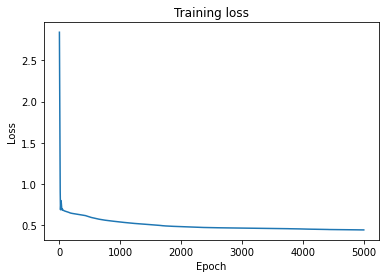

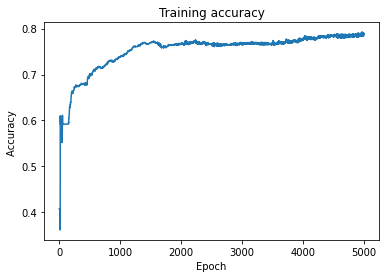

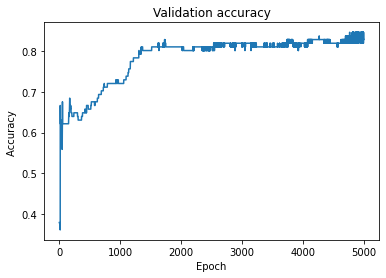

In [ ]:
show_epoch_plot(epoch_loss, "Training loss", "Loss")
print("")
show_epoch_plot(train_accs, "Training accuracy", "Accuracy ")
print("")
show_epoch_plot(val_accs, "Validation accuracy", "Accuracy ")

We report a final test accuracy of 72.3% and final validation accuracy of 83.4%. We observe that the training loss decreases rapidly initially but as training progresses, the training loss plateaus indicating that the model might be stuck in a local minima. We performed an experiment by only decreasing the learning rate to 0.5e-3 and observed a better loss curve which suggests that the model might converge to a better solution. 

Another intresting observation is that there is a big difference (9%) in the test and validation accuracy with validation accuracy being higher. A probable explanation for this is that the random split generated from the seed assigns more difficult samples to the test set. We confirm our hypothesis by running an experimnet using different seeds to split the dataset. This resulted in a lower difference (2%) between the final test and validation accuracy. In order to get a better indicator of both test and validation accuracy, we could run k-fold cross validation and take the average of final models.  



## The end

If you have made it all the way here successfully, congratulations! 🎉 

You have implemented your own GCN and tested it on a node classification task, and a more challenging classification task over multiple graphs.

We hope you can use this knowledge to apply GCNs not only to the tasks described here, but other applications where data can be modeled as a graph.

If you are interested in applying graph neural networks to larger graphs, or try newer architectures, you can dive deeper into [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/), a library with fast implementations for a wide range of architectures. It also comes with custom code that takes care of aspects that you dealt with manually for this assignment, like a more efficient implementation of the adjacency matrix multiplication via message-passing methods, and Data Loaders that relieve you from having to build block diagonal sparse matrices.

You can also check the [Deep Graph Library](https://docs.dgl.ai/) another powerful library for deep learning on graphs which also integrates with other backends like TensorFlow.

# Grading (10pt)

- Question 1: 0.25pt 
- Question 2: 0.25pt 
- Question 3: 0.5pt 
- Question 4: 0.25pt 
- Question 5: 0.5pt 
- Question 6: 0.5pt 
- Question 7: 0.5pt 
- Question 8: 0.5pt 
- Question 9: 1.5pt 
- Question 10: 0.5pt 
- Question 11: 0.25pt 
- Question 12: 0.5pt 
- Question 13: 0.5pt 
- Question 14: 1pt
- Question 15: 1pt
- Question 16: 1.5pt